### Load Factor Prediction Model

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer


#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [7]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')


dataset['wgust'].replace('', np.nan, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
dataset = dataset[dataset['loadFactor']<=1]
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y.shape)
print(X.shape)
# scaler = Normalizer()
# scaled_data = scaler.fit_transform(X)
# print(pd.DataFrame(scaled_data))

print(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)



(2967,)
(2967, 9)
0.3716512685382586


#### Approaches

##### Linear Regression

In [3]:
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

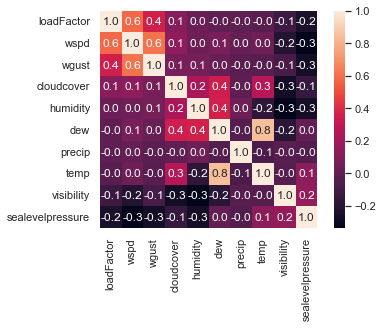

In [8]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True,
                      fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.
Below we scale & standardize the features, before running an evaluation of a set of different models to determine which performs best in our use case.
We here evaluate both linear and nonlinear models.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

print("Linear Models:\n")

potentialLinearModels = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', LassoCV()),
    ('ElasticNet', ElasticNet()),
    ('SGDRegressor', SGDRegressor()),
    ('SVM', SVR())
]

results = []
names = []
for name, model in potentialLinearModels:
    pipeline = Pipeline(
        steps=[('preprocessor', scaler), ('classifier', model)])
    kfold = KFold(n_splits=30)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


print("\nNon-linear Models:\n")


potentialNonLinearModels = [
    ('DecisionTree Regressor', DecisionTreeRegressor()),
    ('KNN Regressor', KNeighborsRegressor()),
    ('GradBoost Regressor', GradientBoostingRegressor()),
    ('ADABoost Regressor', AdaBoostRegressor()),
    ('MLP Regressor', MLPRegressor())
]


results = []
names = []
for name, model in potentialNonLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', Normalizer()),('preprocessor2', StandardScaler()), ('regressor', model)])
    kfold = KFold(n_splits=2)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold,)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


Linear Models:

Linear Regression: 0.316883 (0.090643)
Lasso: 0.317423 (0.089463)
ElasticNet: -0.020660 (0.036322)
SGDRegressor: 0.314010 (0.093448)
SVM: 0.347696 (0.124254)

Non-linear Models:

DecisionTree Regressor: -0.142033 (0.041260)
KNN Regressor: 0.273526 (0.004823)
GradBoost Regressor: 0.338177 (0.007569)
ADABoost Regressor: 0.289486 (0.015022)
MLP Regressor: 0.331111 (0.011670)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Model Definitions
MLP_pipeline = Pipeline(
    steps=[('preprocessor', scaler), ('regressor', MLPRegressor())])

# Parameter Grids
param_grid_MLP = {'regressor__max_iter': [200,300,500],
                  'regressor__solver': ['adam'],
                  'regressor__alpha': [0.0001,0.0005,0.001],
                  'regressor__learning_rate': ['constant', 'adaptive'],
                  'regressor__learning_rate_init': [0.0001, 0.001, 0.01],
                  'regressor__hidden_layer_sizes':[(100,100,500,500,100,100)]
                  }

param_grid_grad_boost = {}

# Grid function definitions
grid_MLP = GridSearchCV(MLP_pipeline, param_grid_MLP,
                        verbose=3, refit=True, n_jobs=-1)

#Solve:
# grid_MLP.fit(X_train,y_train)
# print(grid_MLP.best_params_)
# print(grid_MLP.best_score_)


In [ ]:
from sklearn.model_selection import GridSearchCV
GradBoost_pipeline = Pipeline(
    steps=[('preprocessor', StandardScaler()), ('regressor',
                                      GradientBoostingRegressor())])

param_grid_grad_boost = {
    'regressor__learning_rate':[0.1,0.01,0.001],
    'regressor__alpha':[0.9,0.95],
    'regressor__max_depth':[3,4,5,6],
    'regressor__n_estimators':[100,150,200],
    'regressor__criterion':['friedman_mse', 'squared_error', 'mse'],
    'regressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

grid_gradBoost = GridSearchCV(GradBoost_pipeline,
                              param_grid_grad_boost,
                              verbose=2,
                              refit=True,
                              n_jobs=-1,
                              scoring='neg_root_mean_squared_error')

grid_gradBoost.fit(X_train, y_train)
print(grid_gradBoost.best_params_)
print(grid_gradBoost.best_score_)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.22423489 -0.22349976 -0.22267638 -0.22094107 -0.22208586 -0.22334976
 -0.22142567 -0.22229284 -0.22359153 -0.22111907 -0.22198535 -0.22327503
 -0.3706892  -0.3689258  -0.36600719 -0.35761442 -0.35223163 -0.34956341
 -0.34052631 -0.33554758 -0.33214311 -0.32979744 -0.32523943 -0.31962207
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan       

{'regressor__alpha': 0.95, 'regressor__criterion': 'mse', 'regressor__learning_rate': 0.1, 'regressor__loss': 'huber', 'regressor__max_depth': 4, 'regressor__n_estimators': 150}
-0.219563287667237


In [12]:
# print(grid_gradBoost.best_params_)
MLP_model = Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor',MLPRegressor())])
                                      #MLPRegressor(alpha=0.0005,hidden_layer_sizes=(100,100,100,100,100),learning_rate='constant',learning_rate_init=0.0001,solver='adam')
MLP_model.fit(X_train,y_train)

y_pred = MLP_model.predict(X_test)


print('MLP:')
print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())


gradBoost_model = Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor',GradientBoostingRegressor(max_depth=4,loss='huber',learning_rate=0.1,criterion='mse',alpha=0.95,n_estimators=150))])
                                     
gradBoost_model.fit(X_train,y_train)
y_pred = gradBoost_model.predict(X_test)


print('Grad:')
print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())

MLP:
0.1847137987200066 0.1389307783966668
Grad:
0.17865426664727313 0.14308238049086558


Here we see some not ideal performance results and we find that when using our test dataset, the best scoring models (MLP,gradBoost) achieve roughly 0.17% mean error, and .13% standard deviation.


Our next approach is to attempt to use keras and tensorflow to build a deeper model to see if this shows any improvements in the system. We find that these at best perform around the as our best non-deeplearning based models so will focus on tuning hyperparamters to get a better result from those instead.

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib import pyplot

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(50, input_dim=9, kernel_initializer='normal',kernel_regularizer='l2', activation='relu'))
	model.add(Dense(100, input_dim=50, kernel_initializer='normal',kernel_regularizer='l2', activation='relu'))
	model.add(Dense(250, input_dim=100, kernel_initializer='normal',kernel_regularizer='l2', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='Adam')
	return model

estimators = []
# estimators.append(('standardize', Normalizer()))
estimators.append(('standardize2', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=100, verbose=1)))
pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=5)
# results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
# print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


print('NN:')
print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())


Epoch 1/100
53/53 [==============================] - 1s 481us/step - loss: 0.1316
Epoch 2/100
53/53 [==============================] - 0s 481us/step - loss: 0.0601
Epoch 3/100
53/53 [==============================] - 0s 481us/step - loss: 0.0537
Epoch 4/100
53/53 [==============================] - 0s 500us/step - loss: 0.0543
Epoch 5/100
53/53 [==============================] - 0s 500us/step - loss: 0.0488
Epoch 6/100
53/53 [==============================] - 0s 481us/step - loss: 0.0486
Epoch 7/100
53/53 [==============================] - 0s 481us/step - loss: 0.0471
Epoch 8/100
53/53 [==============================] - 0s 481us/step - loss: 0.0480
Epoch 9/100
53/53 [==============================] - 0s 481us/step - loss: 0.0480
Epoch 10/100
53/53 [==============================] - 0s 500us/step - loss: 0.0426
Epoch 11/100
53/53 [==============================] - 0s 481us/step - loss: 0.0461
Epoch 12/100
53/53 [==============================] - 0s 712us/step - loss: 0.0442
Epoch 13/100
